In [1]:
'''ULS vs TOPAZ
'''



import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4 as nc4
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from src.utils import modif_plot
from src.utils import save_name
from src.utils import tardisml_utils
from src.utils import cmap_manip
from src.data_preparation import load_data
from src.data_preparation import merge_TOPAZ
from src.data_preparation import colocalise_buoys
from src.data_preparation import running_mean as rm
from src.modelling import sit_corrected
from src.feature_extraction import monthly_mean_TP

In [2]:
def getfile_uls_BPEG(idir='', ifile='', buoy='a'):
    '''
    Parameters:
    -----------
        buoy     :   string, name of the buoy. 'a', 'b', 'c', 'd'
    '''

    if idir == '':
        idir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/ULS_BGEP/netcdf/'
    if ifile == '':
        ifile = f'uls{buoy.upper()}_2003_2018.nc'

    return f'{idir}{ifile}'

In [3]:
def getfile_uls_NPEO(idir='', ifile='', buoy=''):
    '''Import NPEO buoy (only one)
    '''
    if idir == '':
        idir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/ULS_NPEO/netcdf/'
    if ifile == '':
        ifile = 'uls_NPEO_2001_2008.nc'
        
    return f'{idir}{ifile}'
    

In [4]:
def getfile_uls_ADCP(idir='', ifile='', buoy='Khatanga'):
    '''Import ADCP buoys
    Parameters:
    -----------
    
        buoy     :   string, name/place of the buoy.
                     can be: 'Anabar', 'Khatanga', 'Lena', 'OuterShelf'
    '''
    import glob
    
    if idir == '':
        idir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/ADCP_Transdrift/netcdf/'
    if ifile == '':
        # glob the file
        ifile = f'adcp_Transdrift_{buoy}*.nc'
        ifile = glob.glob(f'{idir}{ifile}')[0]
    
    return f'{ifile}'
    

In [5]:
def getfile_uls_Fram(idir='', ifile='', buoy='F14'):
    '''Import Fram buoys
    Parameters:
    -----------
            buoy     :       'F11', 'F12', 'F13', 'F14'
    '''
    
    if idir == '':
        idir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/ULS_Fram/netcdf/'
    if ifile == '':
        #ifile = f'uls{buoy.upper()}_2003_2018.nc'
        ifile = f'ULS_{buoy.upper()}_Sumata_SITm_1990_2019.nc'
    
    return f'{idir}{ifile}'
    

In [6]:
def import_uls(ifile):
    '''
    Return sea ice thickness, SIT standard deviation, latitude, longitude and time
    
    ADCP only have daily values >> no standard deviation
    
    Parameters:
    -----------
        ifile     :   string, absolute path of the .nc file to open
    '''
    nc = nc4.Dataset(f'{ifile}', mode='r')
    sit = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['sit']
    
    if 'ADCP' in ifile:
        sit_std = None
    else:
        sit_std = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['sit_std']

    lat = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['lat']
    lon = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['lon']

    chrono = pd.DataFrame({'date':pd.to_datetime(sit.time)})

    chrono_dt_uls = np.array([dt.date() for dt in chrono.date])
    
    return sit, sit_std, lat, lon, chrono_dt_uls

In [7]:
def smooth_uls(sit, sit_std, ndays=7, buoy_type=''):
    '''Smooth with a running mean
    
    Parameters:
    -----------
        sit      : xarray.DataArray, Sea ice thickness
        sit_std  : xarray.DataArray, SIT standard deviation
        ndays    : int, number of days for the running window
    '''

    # smoothing
    sit_smooth = np.array(rm.center_running_mean(sit.to_numpy(), ndays, npd=1))

    # Convert numpy to xarray
    sit_sm = xr.DataArray(
        data=sit_smooth,
        dims=["time"],
        coords=dict(
            time=(['time'], sit.time.data)
        ),
        attrs=dict(
            standard_name='sit',
            description="SIT with averaging window over 1 week",
            long_name='mean sea ice thickness',
            unit='m',
            ULS=f'{buoy_type}'
        ),)

    if sit_std is None:  # observation might not have standard deviation
        return sit_sm, None

    sit_std_smooth = np.array(rm.center_running_mean(sit_std.to_numpy(), ndays, npd=1))
    
    sit_std_sm = xr.DataArray(
        data=sit_std_smooth,
        dims=["time"],
        coords=dict(
            time=(['time'], sit_std.time.data)
        ),
        attrs=dict(
            standard_name='sit',
            description="SIT with averaging window over 1 week",
            long_name='std sea ice thickness',
            unit='m',
            ULS=f'{buoy_type}'
        ),)

    return sit_sm, sit_std_sm

In [25]:
def draw_sit_uls(chrono_dt_uls, sit_uls, sit_std_uls, 
                 valid_ll_fr, sit_na_loc, sit_bl_loc, 
                 valid_ll, sit_ml_loc,
                 buoy='', rootdir='', savefig=False, showfig=False):

    
    # detect if there is a gap in chrono
    increment_days = chrono_dt_uls[1:]-chrono_dt_uls[:-1]  # number of days between 2 dates
    mask_gap = np.array([x.days>1 for x in increment_days] + [False])

    sit_plt = sit_uls.copy()
    sit_na_loc_plt = sit_na_loc.copy()
    sit_bl_loc_plt = sit_bl_loc.copy()
    sit_ml_loc_plt = sit_ml_loc.copy()

    if np.any(mask_gap):
        sit_plt[mask_gap] = np.nan
        sit_na_loc_plt[mask_gap[valid_ll_fr]] = np.nan
        sit_bl_loc_plt[mask_gap[valid_ll_fr]] = np.nan
        sit_ml_loc_plt[mask_gap[valid_ll]] = np.nan
    

    date_first_uls = chrono_dt_uls[0]
    date_last_uls = chrono_dt_uls[-1]

    date_min = date_first_uls - datetime.timedelta(days=30) # datetime.datetime(2011,1,1)
    #date_max = date_last_uls + datetime.timedelta(days=30) # datetime.datetime(2020,1,1)
#     date_min = datetime.datetime(2003,8,14)
    date_max = datetime.datetime(2010,12,31)
#     date_max = datetime.datetime(2010,12,31)

#     odir = f'{rootdir}Leo/results/ULS_BGEP/'
#     odir = f'{rootdir}Leo/results/ULS_BGEP_240405-180331/'
    odir = f'{rootdir}Leo/results/ULS_BGEP_240523-170100/'
    odir = f'{rootdir}Leo/results/ULS_BGEP_240524-173523/'
    
    
    ofile = f'uls{buoy.upper().replace(" ","")}_SIT_TOPAZ_{date_min.year}_{date_max.year}_01.png'
    
    
    # -----------------   Plot -------------------------------------
    fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)

    # ULS
    plt.plot(chrono_dt_uls, sit_plt, c='k', ls='--', lw=2, label=f'{buoy}')  #ULS {buoy.upper()}')
    if sit_std_uls is not None:
        plt.fill_between(chrono_dt_uls, sit_uls+sit_std_uls, sit_uls-sit_std_uls, color='grey', alpha=0.2, where=~mask_gap)

    # TOPAZ
    plt.plot(chrono_dt_uls[valid_ll_fr], sit_na_loc_plt, label='TOPAZ4-FR', c='#1295B2')
    plt.plot(chrono_dt_uls[valid_ll_fr], sit_bl_loc_plt, label='TOPAZ4-BL', c='#7E8A8A')
    plt.plot(chrono_dt_uls[valid_ll], sit_ml_loc_plt, label='TOPAZ4-ML', c='#FB6949', lw=2)

    ax.set_ylim([0, 5])
    if 'NPEO' in buoy:
        ax.set_ylim([0, 7])
        
    ax.set_xlim([date_min, date_max])


    ax.set_ylabel('SIT (m)')
    # ax.set_title(f'Mooring {buoy.upper()}')
    plt.legend(fontsize=18, ncol=4)
    ax.spines[['right', 'top']].set_visible(False)
    ax.xaxis.grid(alpha=0.6)

    modif_plot.resize(fig, s=24, rx=-20)

    if savefig:
        ofile = save_name.check(f"{odir}", ofile)
        plt.savefig(f"{odir}{ofile}", dpi=200, facecolor='white')
        print(f'Figure saved as : {odir}{ofile}')

    

In [9]:
def compute_seasonal_errors(sit_ml_locDA, sit_bl_locDA, sit_na_locDA, sit_uls, print_latex=False):
    '''Compute Bias/RMSE/Corr
    
    Parameters:
    -----------
        sit_ml_locDA      : xarray.DataArray, Sea ice thickness TOPAZ ML-adjusted colocated with ULS
        sit_bl_locDA      : xarray.DataArray, Sea ice thickness TOPAZ baseline colocated with ULS
        sit_na_locDA      : xarray.DataArray, Sea ice thickness TOPAZ FreeRun colocated with ULS
        sit_uls           : xarray.DataArray, SIT ULS
    '''

    seasons = ['DJF', 'MAM', 'JJA', 'SON']


    sits_ml = sit_ml_locDA.groupby('time.season')
    sits_bl = sit_bl_locDA.groupby('time.season')
    sits_na = sit_na_locDA.groupby('time.season')
    
    sits_uls = sit_uls.groupby('time.season')
    # DataArrayGroupBy, grouped over 'season'
    # 4 groups with labels 'DJF', 'JJA', 'MAM', 'SON'.

    # -------------- Machine learning

    bias_season = np.array([(sits_ml[saison] - sits_uls[saison]).mean() for saison in seasons])
    rmse_season = np.array([np.sqrt((np.square(sits_ml[saison] - sits_uls[saison])).mean()) for saison in seasons])
    corr_season = np.array([xr.corr(sits_ml[saison], sits_uls[saison]) for saison in seasons])

    biasm = bias_season.mean()
    rmsem = rmse_season.mean()
    corrm = corr_season.mean()

    # --------------- Baseline

    bias_bl_season = np.array([(sits_bl[saison] - sits_uls[saison]).mean() for saison in seasons])
    rmse_bl_season = np.array([np.sqrt((np.square(sits_bl[saison] - sits_uls[saison])).mean()) for saison in seasons])
    corr_bl_season = np.array([xr.corr(sits_bl[saison], sits_uls[saison]) for saison in seasons])

    biasm_bl = bias_bl_season.mean()
    rmsem_bl = rmse_bl_season.mean()
    corrm_bl = corr_bl_season.mean()

    # ---------------- Freerun
    
    bias_na_season = np.array([(sits_na[saison] - sits_uls[saison]).mean() for saison in seasons])
    rmse_na_season = np.array([np.sqrt((np.square(sits_na[saison] - sits_uls[saison])).mean()) for saison in seasons])
    corr_na_season = np.array([xr.corr(sits_na[saison], sits_uls[saison]) for saison in seasons])

    biasm_na = bias_na_season.mean()
    rmsem_na = rmse_na_season.mean()
    corrm_na = corr_na_season.mean()

    
    # --------------- Print results  -------------------------------------


    print(f'\n\nULS {buoy.upper()}:    [ML-adjusted - ULS] \n')
    print('mean Bias    |      mean  RMSE   |   mean corr')
    print(f'{biasm:.03f}                {rmsem:.03f}            {corrm:.03f}')

    print('\n\tDJF     |   MAM     |    JJA      |    SON   ')
    print(f'Bias\t{bias_season[0]:.03f}      {bias_season[1]:.03f} \
          {bias_season[2]:.03f}        {bias_season[3]:.03f}')

    print(f'RMSE\t{rmse_season[0]:.03f}      {rmse_season[1]:.03f} \
          {rmse_season[2]:.03f}        {rmse_season[3]:.03f}')

    print(f'Corr\t{corr_season[0]:.03f}      {corr_season[1]:.03f} \
          {corr_season[2]:.03f}        {corr_season[3]:.03f}')



    print(f'\n\nULS {buoy.upper()}:    [Baseline - ULS] \n')
    print('mean Bias    |      mean  RMSE    |    corr')
    print(f'{biasm_bl:.03f}                {rmsem_bl:.03f}            {corrm_bl:.03f}')

    print('\n\tDJF     |   MAM     |    JJA      |    SON   ')
    print(f'Bias\t{bias_bl_season[0]:.03f}      {bias_bl_season[1]:.03f} \
          {bias_bl_season[2]:.03f}        {bias_bl_season[3]:.03f}')


    print(f'RMSE\t{rmse_bl_season[0]:.03f}      {rmse_bl_season[1]:.03f} \
          {rmse_bl_season[2]:.03f}        {rmse_bl_season[3]:.03f}')

    print(f'Corr\t{corr_bl_season[0]:.03f}      {corr_bl_season[1]:.03f} \
          {corr_bl_season[2]:.03f}        {corr_bl_season[3]:.03f}')
    
    
    if print_latex:
        print('\nLatex table:')
        print('Bias, RMSE, Corr')

        print(f'{bias_season[0]:.02f}&{bias_bl_season[0]:.02f}&{bias_na_season[0]:.02f}&'
                f'{bias_season[1]:.02f}&{bias_bl_season[1]:.02f}&{bias_na_season[1]:.02f}&'
                f'{bias_season[2]:.02f}&{bias_bl_season[2]:.02f}&{bias_na_season[2]:.02f}&'
                f'{bias_season[3]:.02f}&{bias_bl_season[3]:.02f}&{bias_na_season[3]:.02f}&')
              
        print(f'{rmse_season[0]:.02f}&{rmse_bl_season[0]:.02f}&{rmse_na_season[0]:.02f}&'
                f'{rmse_season[1]:.02f}&{rmse_bl_season[1]:.02f}&{rmse_na_season[1]:.02f}&'
                f'{rmse_season[2]:.02f}&{rmse_bl_season[2]:.02f}&{rmse_na_season[2]:.02f}&'
                f'{rmse_season[3]:.02f}&{rmse_bl_season[3]:.02f}&{rmse_na_season[3]:.02f}&')

        print(f'{corr_season[0]:.02f}&{corr_bl_season[0]:.02f}&{corr_na_season[0]:.02f}&'
                f'{corr_season[1]:.02f}&{corr_bl_season[1]:.02f}&{corr_na_season[1]:.02f}&'
                f'{corr_season[2]:.02f}&{corr_bl_season[2]:.02f}&{corr_na_season[2]:.02f}&'
                f'{corr_season[3]:.02f}&{corr_bl_season[3]:.02f}&{corr_na_season[3]:.02f}&')

In [10]:
from scipy import stats
def compute_errors(sit_ml_loc, sit_bl_loc, sit_na_loc, sit, print_latex=False):
    '''Compute Bias/RMSE/Corr on average
    '''
    
    # corr between sit[valid_ll] and sit_ml_loc
#     x = sit[valid_ll]
#     y = sit_ml_loc

#     x = sit[valid_ll]
#     y = sit_bl_loc

    # remove nan
    tp_ml = sit_ml_loc[~np.isnan(sit)]  # topaz
    ref = sit[~np.isnan(sit)]  # reference = obs
    tp_bl = sit_bl_loc[~np.isnan(sit)]  # topaz
    tp_na = sit_na_loc[~np.isnan(sit)]  # topaz
    
    
    c_val_ml, p_val_ml = stats.pearsonr(tp_ml, ref)  # returns correlation value, p value
    rmse_ml = np.sqrt((np.square(tp_ml-ref)).mean())
    bias_ml = (tp_ml - ref).mean()
    
    c_val_bl, p_val_bl = stats.pearsonr(tp_bl, ref)  # returns correlation value, p value
    rmse_bl = np.sqrt((np.square(tp_bl-ref)).mean())
    bias_bl = (tp_bl - ref).mean()

    c_val_na, p_val_na = stats.pearsonr(tp_na, ref)  # returns correlation value, p value
    rmse_na = np.sqrt((np.square(tp_na-ref)).mean())
    bias_na = (tp_na - ref).mean()
    
    
    # check if biases are significatively different
    _, pval_bias = stats.pearsonr((tp_ml - ref) ,(tp_bl - ref))
    
    print('\n\nML-adjusted - ULS')
    print(f'bias  :      {bias_ml.data:.03f}')
    print(f'rmse  :      {rmse_ml.data:.03f}')
    print(f'mean corr:   {c_val_ml:.03f}     p value:    {p_val_ml:.06f}')

    
    print('\n\nBaseline - ULS')
    print(f'bias  :      {bias_bl.data:.03f}')
    print(f'rmse  :      {rmse_bl.data:.03f}')
    print(f'mean corr:   {c_val_bl:.03f}     p value:    {p_val_bl:.06f}')    
    
    print(f'P value for bias:   {pval_bias:.03f}')
    
    if print_latex:
        print('\nLatex table:')
        print('Bias, RMSE, Corr')
#         print(f'{bias_ml.data:.03f} ({bias_bl.data:.03f}) & {rmse_ml.data:.03f} ({rmse_bl.data:.03f}) & {c_val_ml:.03f} ({c_val_bl:.03f})\\')
        print(f'{bias_ml.data:.02f}&{bias_bl.data:.02f}&{bias_na.data:.02f}\\\n'
              f'{rmse_ml.data:.02f}&{rmse_bl.data:.02f}&{rmse_na.data:.02f}\\\n'
              f'{c_val_ml:.02f}&{c_val_bl:.02f}&{c_val_na:.02f}\\')

    

In [11]:
# -----------------------------------------------


rootdir = tardisml_utils.get_rootdir()

In [35]:
# -------------- Get ULS filename ------------------------

buoy_type = 'BGEP'  # 'BGEP' / 'NPEO' / 'ADCP' / 'Fram'

if buoy_type == 'BGEP':
    buoy = 'c'  # 'a', 'b', 'c', 'd'
    ifile = getfile_uls_BPEG(idir='', ifile='', buoy=buoy)

if buoy_type == 'NPEO':
    buoy=''
    ifile = getfile_uls_NPEO()
    
if buoy_type == 'ADCP':
    buoy = 'Lena'  # 'Anabar', 'Khatanga', 'Lena', 'OuterShelf'
    ifile = getfile_uls_ADCP(buoy=buoy)
    
if buoy_type == 'Fram':
    buoy = 'F14'
    ifile = getfile_uls_Fram()    

In [36]:
# Total buoy name

buoy_name = f'{buoy_type}'
if buoy != '' and buoy_type == 'BGEP':
    buoy_name += f' {buoy.upper()}'
elif buoy != '' and buoy_type == 'ADCP':
    buoy_name += f' {buoy}'
elif buoy != '' and buoy_type == 'Fram':
    buoy_name += f' {buoy}'

In [37]:
# -------------- Import ULS SIT ------------------------

sit_uls, sit_std_uls, lat, lon, chrono_dt_uls = import_uls(ifile=ifile)
sit_sm, sit_std_sm = smooth_uls(sit_uls, sit_std_uls, ndays=7, buoy_type=buoy_type)

/users/edelleo1/tardis/tardis-ml/src/data_preparation/running_mean.py:49: RuntimeWarning: Mean of empty slice
  window_average = np.nanmean(arr[-idx:-1])


In [16]:
from importlib import reload

In [17]:
reload(sit_corrected)

<module 'src.modelling.sit_corrected' from '/users/edelleo1/tardis/tardis-ml/src/modelling/sit_corrected.py'>

In [15]:
# -------------- Import TOPAZ ------------------------

# ipath = 'Leo/results/lstm_230919-170402/'
ipath = 'Leo/results/lstm_231212-183758/'
# ipath = 'Leo/results/lstm_240405-180331/'  # adjSIC full opti1
# ipath = 'Leo/results/lstm_240507-160336/'  # best of the best (?)
ipath = 'Leo/results/lstm_240523-170100/'  
ipath = 'Leo/results/lstm_240524-173523/'   # N24



ml_name ='LSTM'

ifile = f'{rootdir}{ipath}'
m2000 = sit_corrected.SITCorrected(ifile, name=ml_name, verbose=1, objective='apply')

Config file found: /scratch/project_465000269/edelleo1/Leo/results/lstm_240524-173523/config_default_2023_adjSIC_full_pm1M_batch32-opti1-v2-sia_N24.yaml
Config file updated 'needpast': /scratch/project_465000269/edelleo1/Leo/results/lstm_240524-173523/config_default_2023_adjSIC_full_pm1M_batch32-opti1-v2-sia_N24.yaml
Config file updated 'needfutur': /scratch/project_465000269/edelleo1/Leo/results/lstm_240524-173523/config_default_2023_adjSIC_full_pm1M_batch32-opti1-v2-sia_N24.yaml
Folder: Leo/results/lstm_240524-173523/figures/sit_reconstruct/

Initialisation SIT from LSTM
ML prediction .nc file found: /scratch/project_465000269/edelleo1/Leo/results/lstm_240524-173523/ml/ypred_LSTM3_bk_1998_2011_Freerun.nc


In [16]:
#  Reconstruct SIT values 
m2000.reconstruct_sit()
# m2000.compute_mean(sic_min=0.15)

merge_TOPAZ.cut_sit(m2000, datetime.date(1999,1,1), datetime.date(2011,1,30))

sit_ml = m2000.sit
sit_na = m2000.sit_na
sit_bl = m2000.sit_bl

# Cap negative value at 0 m (while keeping nan)
sit_ml = (sit_ml.where((0<sit_ml), 0)).where(np.isfinite(sit_ml))
sit_bl = (sit_bl.where((0<sit_bl), 0)).where(np.isfinite(sit_bl))

In [17]:
# get monthly mean if buoy in fram
if buoy_type == 'Fram':
    sit_ml = monthly_mean_TP.compute_mm(sit_ml)
    sit_bl = monthly_mean_TP.compute_mm(sit_bl)    
    sit_na = monthly_mean_TP.compute_mm(sit_na)

In [18]:
# chrono_dt_ml = np.array([dt.date() for dt in m2000.chrono.date])
chrono_ml = pd.DataFrame({'date':pd.to_datetime(sit_ml.time)})
chrono_dt_ml = np.array([dt.date() for dt in chrono_ml.date])

# chrono_na = m2000.sit_na.time
# chrono_fr = pd.DataFrame({'date':pd.to_datetime(m2000.sit_na.time.to_numpy())})
chrono_fr = pd.DataFrame({'date':pd.to_datetime(sit_na.time.to_numpy())})
chrono_dt_fr = np.array([dt.date() for dt in chrono_fr.date])

In [38]:
# -------------- Colocate TOPAZ to ULS (time/space) ------------------------

sit_ml_loc, lats, lons, valid_ll = colocalise_buoys.get_closest_arr(lat, lon, chrono_dt_uls, sit_ml, chrono_dt_ml)
sit_na_loc, _, _, valid_ll_fr = colocalise_buoys.get_closest_arr(lat, lon, chrono_dt_uls, sit_na, chrono_dt_fr)
sit_bl_loc, _, _, _ = colocalise_buoys.get_closest_arr(lat, lon, chrono_dt_uls, sit_bl, chrono_dt_fr)

sit_ml_locDA = xr.DataArray(sit_ml_loc, 
                coords={'time': sit_uls.time[valid_ll]},
                dims=["time"])
sit_bl_locDA = xr.DataArray(sit_bl_loc, 
                coords={'time': sit_uls.time[valid_ll_fr]},
                dims=["time"])

sit_na_locDA = xr.DataArray(sit_na_loc, 
                coords={'time': sit_uls.time[valid_ll_fr]},
                dims=["time"])

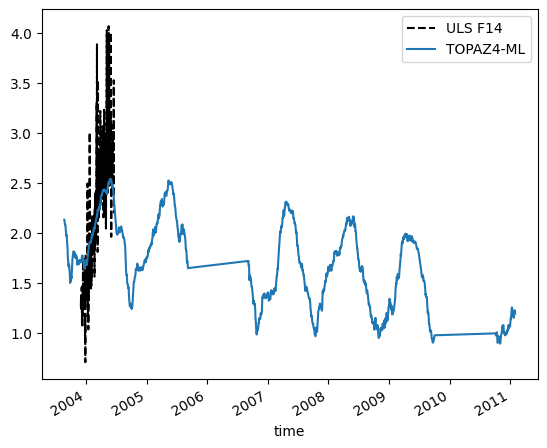

In [33]:
sit_uls.where(sit_uls>0).isel(time=slice(100,300)).plot(c='k', ls='--', label='ULS F14')
sit_ml_locDA.plot(label='TOPAZ4-ML')
# sit_bl_locDA.plot(label='TOPAZ4-BL')
# sit_na_locDA.plot(label='TOPAZ4-FR')
plt.legend()

Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/ULS_BGEP_240524-173523/ulsBGEPC_SIT_TOPAZ_2003_2010_01.png


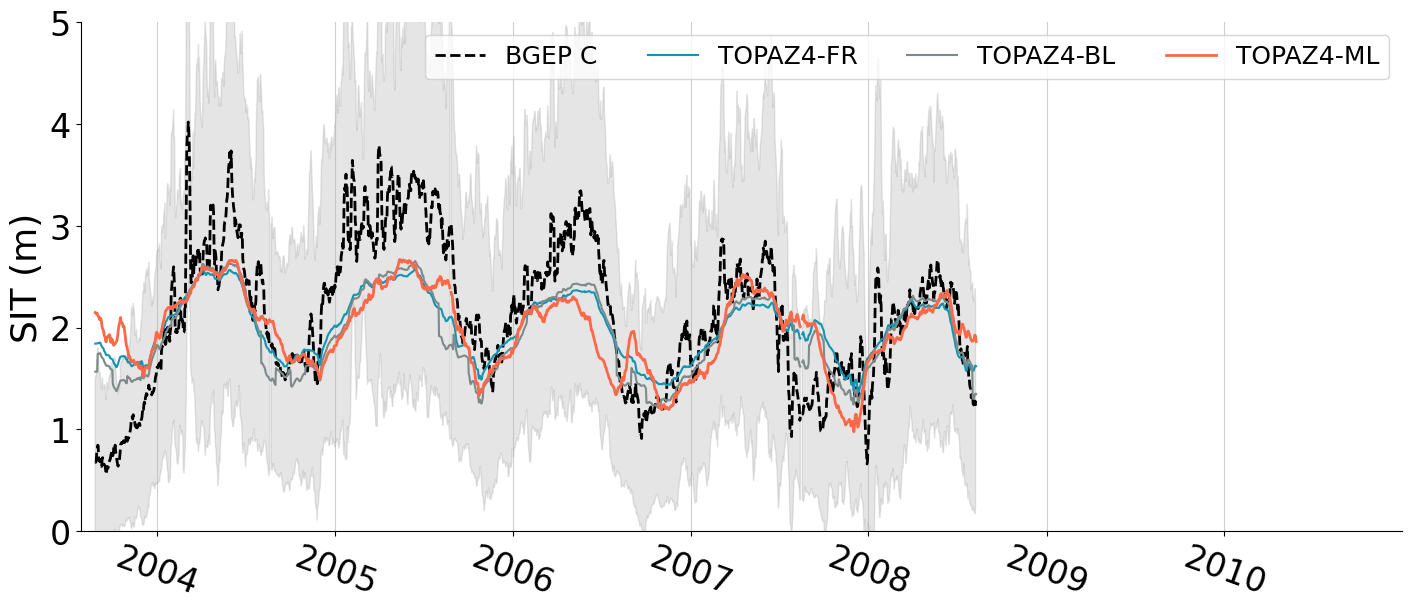

In [39]:
# -------------- Plot ------------------------

draw_sit_uls(chrono_dt_uls, sit_sm, sit_std_sm, 
             valid_ll_fr, sit_na_loc, sit_bl_loc, 
             valid_ll, sit_ml_loc,
             buoy=buoy_name, rootdir=rootdir, savefig=True, showfig=True)

In [24]:
# ----------------- Compute Bias/RMSE/Corr -----------------------

# compute_errors(sit_ml_loc, sit_bl_loc, sit_sm[valid_ll], print_latex=True)

# compute_seasonal_errors(sit_ml_locDA, sit_bl_locDA, sit_uls)

In [25]:
# ----------------- Compute Bias/RMSE/Corr -----------------------

# compute_errors(sit_ml_loc, sit_bl_locDA, sit_na_loc, sit_sm[valid_ll], print_latex=True)

In [26]:
# compute_seasonal_errors(sit_ml_locDA, sit_bl_locDA, sit_na_locDA, sit_uls, print_latex=True)

## Compute for freezing and melting seasons

In [27]:
def compute_2seasons_errors(sit_ml_locDA, sit_bl_locDA, sit_na_locDA, sit_uls, print_latex=False):
    '''Compute Bias/RMSE/Corr
    
    Parameters:
    -----------
        sit_ml_locDA      : xarray.DataArray, Sea ice thickness TOPAZ ML-adjusted colocated with ULS
        sit_bl_locDA      : xarray.DataArray, Sea ice thickness TOPAZ baseline colocated with ULS
        sit_na_locDA      : xarray.DataArray, Sea ice thickness TOPAZ FreeRun colocated with ULS
        sit_uls           : xarray.DataArray, SIT ULS
    '''

    seasons_str = ['ONDJFMA', 'MJJAS']
    mask_freezing = ((sit_uls.time.dt.month==10) | (sit_uls.time.dt.month==11) |
                     (sit_uls.time.dt.month==12) | (sit_uls.time.dt.month==1)  |
                     (sit_uls.time.dt.month==2)  | (sit_uls.time.dt.month==3)  |
                     (sit_uls.time.dt.month==4))

    seasons = [mask_freezing, ~mask_freezing]

    # -------------- Machine learning

    bias_season = np.array([(sit_ml_locDA[saison] - sit_uls[saison]).mean() for saison in seasons])
    rmse_season = np.array([np.sqrt((np.square(sit_ml_locDA[saison] - sit_uls[saison])).mean()) for saison in seasons])
    corr_season = np.array([xr.corr(sit_ml_locDA[saison], sit_uls[saison]) for saison in seasons])

    biasm = bias_season.mean()
    rmsem = rmse_season.mean()
    corrm = corr_season.mean()

    # --------------- Baseline

    bias_bl_season = np.array([(sit_bl_locDA[saison] - sit_uls[saison]).mean() for saison in seasons])
    rmse_bl_season = np.array([np.sqrt((np.square(sit_bl_locDA[saison] - sit_uls[saison])).mean()) for saison in seasons])
    corr_bl_season = np.array([xr.corr(sit_bl_locDA[saison], sit_uls[saison]) for saison in seasons])

    biasm_bl = bias_bl_season.mean()
    rmsem_bl = rmse_bl_season.mean()
    corrm_bl = corr_bl_season.mean()

    # ---------------- Freerun
    
    bias_na_season = np.array([(sit_na_locDA[saison] - sit_uls[saison]).mean() for saison in seasons])
    rmse_na_season = np.array([np.sqrt((np.square(sit_na_locDA[saison] - sit_uls[saison])).mean()) for saison in seasons])
    corr_na_season = np.array([xr.corr(sit_na_locDA[saison], sit_uls[saison]) for saison in seasons])

    biasm_na = bias_na_season.mean()
    rmsem_na = rmse_na_season.mean()
    corrm_na = corr_na_season.mean()

    
    # --------------- Print results  -------------------------------------


    print(f'\n\nULS {buoy.upper()}:    [TOPAZ4-ML - ULS] \n')
    print('mean Bias    |      mean  RMSE   |   mean corr')
    print(f'{biasm:.03f}                {rmsem:.03f}            {corrm:.03f}')

    print(f'\n\t{seasons_str[0]:10}    |{seasons_str[1]:10}')
    print(f'Bias\t{bias_season[0]:10.03f}    |{bias_season[1]:10.03f}')
    print(f'RMSE\t{rmse_season[0]:10.03f}    |{rmse_season[1]:10.03f}')
    print(f'Corr\t{corr_season[0]:10.03f}    |{corr_season[1]:10.03f}')



    print(f'\n\nULS {buoy.upper()}:    [TOPAZ4-BL - ULS] \n')
    print('mean Bias    |      mean  RMSE    |    corr')
    print(f'{biasm_bl:.03f}                {rmsem_bl:.03f}            {corrm_bl:.03f}')

    print(f'\n\t{seasons_str[0]:10}    |{seasons_str[1]:10}')    
    print(f'Bias\t{bias_bl_season[0]:10.03f}    |{bias_bl_season[1]:10.03f}')
    print(f'RMSE\t{rmse_bl_season[0]:10.03f}    |{rmse_bl_season[1]:10.03f}')
    print(f'Corr\t{corr_bl_season[0]:10.03f}    |{corr_bl_season[1]:10.03f}')
    
    print(f'\n\nULS {buoy.upper()}:    [TOPAZ4-FR - ULS] \n')
    print('mean Bias    |      mean  RMSE    |    corr')
    print(f'{biasm_na:.03f}                {rmsem_na:.03f}            {corrm_na:.03f}')

    print(f'\n\t{seasons_str[0]:10}    |{seasons_str[1]:10}')    
    print(f'Bias\t{bias_na_season[0]:10.03f}    |{bias_na_season[1]:10.03f}')
    print(f'RMSE\t{rmse_na_season[0]:10.03f}    |{rmse_na_season[1]:10.03f}')
    print(f'Corr\t{corr_na_season[0]:10.03f}    |{corr_na_season[1]:10.03f}')
    
    
    
    if print_latex:
        print('\nLatex table:')
        print('Bias, RMSE, Corr')

        print(f'{bias_season[0]:.02f}&{bias_bl_season[0]:.02f}&{bias_na_season[0]:.02f}&'
                f'{bias_season[1]:.02f}&{bias_bl_season[1]:.02f}&{bias_na_season[1]:.02f}&'
                f'{biasm:.02f}&{biasm_bl:.02f}&{biasm_na:.02f}')
              
        print(f'{rmse_season[0]:.02f}&{rmse_bl_season[0]:.02f}&{rmse_na_season[0]:.02f}&'
                f'{rmse_season[1]:.02f}&{rmse_bl_season[1]:.02f}&{rmse_na_season[1]:.02f}&'
                f'{rmsem:.02f}&{rmsem_bl:.02f}&{rmsem_na:.02f}')

        print(f'{corr_season[0]:.02f}&{corr_bl_season[0]:.02f}&{corr_na_season[0]:.02f}&'
                f'{corr_season[1]:.02f}&{corr_bl_season[1]:.02f}&{corr_na_season[1]:.02f}&'
                f'{corrm:.02f}&{corrm_bl:.02f}&{corrm_na:.02f}')

In [54]:
compute_2seasons_errors(sit_ml_locDA, sit_bl_locDA, sit_na_locDA, sit_sm[valid_ll], print_latex=True)



ULS D:    [TOPAZ4-ML - ULS] 

mean Bias    |      mean  RMSE   |   mean corr
-0.006                0.820            0.172

	ONDJFMA       |MJJAS     
Bias	    -0.327    |     0.314
RMSE	     0.733    |     0.906
Corr	    -0.006    |     0.350


ULS D:    [TOPAZ4-BL - ULS] 

mean Bias    |      mean  RMSE    |    corr
-0.043                0.651            0.508

	ONDJFMA       |MJJAS     
Bias	    -0.124    |     0.037
RMSE	     0.578    |     0.724
Corr	     0.423    |     0.594


ULS D:    [TOPAZ4-FR - ULS] 

mean Bias    |      mean  RMSE    |    corr
0.175                0.764            0.243

	ONDJFMA       |MJJAS     
Bias	     0.068    |     0.282
RMSE	     0.599    |     0.930
Corr	     0.284    |     0.203

Latex table:
Bias, RMSE, Corr
-0.33&-0.12&0.07&0.31&0.04&0.28&-0.01&-0.04&0.17
0.73&0.58&0.60&0.91&0.72&0.93&0.82&0.65&0.76
-0.01&0.42&0.28&0.35&0.59&0.20&0.17&0.51&0.24


In [48]:
compute_2seasons_errors(sit_ml_locDA, sit_bl_locDA, sit_na_locDA, sit_sm[valid_ll], print_latex=True)



ULS C:    [TOPAZ4-ML - ULS] 

mean Bias    |      mean  RMSE   |   mean corr
-0.416                0.725            0.611

	ONDJFMA       |MJJAS     
Bias	    -0.537    |    -0.295
RMSE	     0.752    |     0.698
Corr	     0.625    |     0.597


ULS C:    [TOPAZ4-BL - ULS] 

mean Bias    |      mean  RMSE    |    corr
-0.191                0.493            0.822

	ONDJFMA       |MJJAS     
Bias	    -0.193    |    -0.189
RMSE	     0.440    |     0.546
Corr	     0.827    |     0.818


ULS C:    [TOPAZ4-FR - ULS] 

mean Bias    |      mean  RMSE    |    corr
-0.136                0.514            0.828

	ONDJFMA       |MJJAS     
Bias	    -0.114    |    -0.158
RMSE	     0.448    |     0.579
Corr	     0.823    |     0.833

Latex table:
Bias, RMSE, Corr
-0.54&-0.19&-0.11&-0.29&-0.19&-0.16&-0.42&-0.19&-0.14
0.75&0.44&0.45&0.70&0.55&0.58&0.73&0.49&0.51
0.63&0.83&0.82&0.60&0.82&0.83&0.61&0.82&0.83
